# 2장 넘파이와 사이파이의 분위수 정규화

In [20]:
import numpy as np
from scipy import stats

def quantile_norm(X):
    """ 각 분포가 같은 X열을 정규화한다.

    N개 샘플의 M 유전자 발현 행렬(유전자미세배열, 판독 수 등)이 주어짐. 
    분위수 정규화는 (설정에 의해) 모든 샘플이 동일한 데이터 범위를 갖는다.

    각 행의 평균을 구해 평균 열을 얻는다. 
    각 열의 분위수는 평균 열의 해당 분위수로 대체된다.

    매개변수
    ----------
    X : 부동 소수점 2차원 배열 (M, N)
        M : 유전자/특징 (행)
        N : 샘플 (열)

    반환값
    -------
    Xn : 부동 소수점 2차원 배열 (M, N)
        정규화된 데이터
    """

    # 분위수 계산
    quantiles = np.mean(np.sort(X, axis=0), axis=1)

    # 열 별 순위 계산
    # 각 측정값의 해당 열의 순위를 구한다.
    # 가장 작은 값은 1, 두 번째로 작은 값은 2, …, 가장 큰 값은 M으로 바뀐다.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # 0 에서 M-1 까지의 정수 인덱스로 순위를 변환한다.
    rank_indices = ranks.astype(int) - 1

    # 순위 행렬의 각 순위에 대한 분위수를 인덱싱한다.
    Xn = quantiles[rank_indices]

    return(Xn)

In [21]:
def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

## 2.1 데이터 가져오기

In [22]:
import numpy as np
import pandas as pd

# TCGA 흑색종(melanoma) 데이터 불러오기
filename = 'data/counts.txt'
data_table = pd.read_csv(filename, index_col=0)  # 팬더스로 파일 파싱

print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


In [4]:
# 각 개체의 유전자 발현 개수를 포함하는 2차원 ndarray
counts = data_table.values

## 2.2 개체 간 유전자 발현 분포의 차이

In [23]:
# 그래프를 바로 표시하고, 사용자 정의 스타일을 적용한다.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

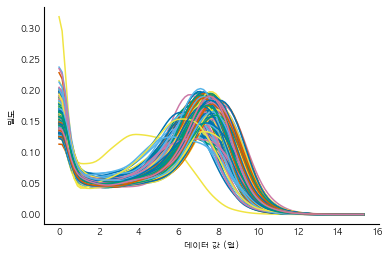

In [12]:
from scipy import stats

def plot_col_density(data):
    """각 열의 모든 행에 대한 밀도 그래프를 생성한다."""

    # 커널 밀도 추정을 사용한다.
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)

    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('데이터 값 (열)')
    ax.set_ylabel('밀도')

# 정규화하기 전
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

In [10]:
import numpy as np
from scipy import stats

def quantile_norm(X):
    """ 각 분포가 같은 X열을 정규화한다.

    N개 샘플의 M 유전자 발현 행렬(유전자미세배열, 판독 수 등)이 주어진다. 
    분위수 정규화는 (설정에 의해) 모든 샘플이 동일한 데이터 범위를 갖는다.

    각 행의 평균을 구해 평균 열을 얻는다. 
    각 열의 분위수는 평균 열의 해당 분위수로 대체된다.

    매개변수
    ----------
    X : 부동 소수점 2차원 배열 (M, N)
        M : 유전자/특징 (행)
        N : 샘플 (열)


    반환값
    -------
    Xn : 부동 소수점 2차원 배열 (M, N)
        정규화된 데이터
    """

    # 분위수 계산
    quantiles = np.mean(np.sort(X, axis=0), axis=1)

    # 열 별 순위 계산
    # 각 측정값의 해당 열의 순위를 구한다.
    # 가장 작은 값은 1, 두 번째로 작은 값은 2, …, 가장 큰 값은 M으로 바뀐다.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # 0 에서 M-1 까지의 정수 인덱스로 순위를 변환한다.
    rank_indices = ranks.astype(int) - 1

    # 순위 행렬의 각 순위에 대한 분위수를 인덱싱한다.
    Xn = quantiles[rank_indices]

    return(Xn)

def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

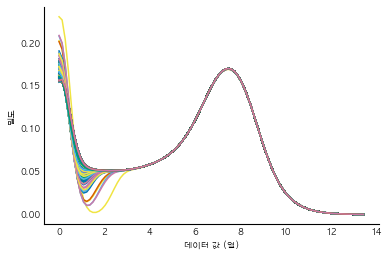

In [13]:
# 분위수 정규화 수행 후
log_counts_normalized = quantile_norm_log(counts)

plot_col_density(log_counts_normalized)

## 2.3 이중군집화 (Biclustering)

In [15]:
def most_variable_rows(data, *, n=1500):
    """가변적인 n행의 서브셋 데이터

    n은 가장 가변적인 유전자의 개수를 말한다.

    매개변수
    ----------
    data : 부동소수점, 2차원 배열
        서브셋 데이터
    n : 정수, 선택적 매개변수
        반환할 행 수

    반환값
    -------
    variable_data : 부동소수점, 2차원 배열
        변화가 큰 데이터 n개의 행
    """
    # 열 축을 따라 분산(variance)을 계산한다.
    rowvar = np.var(data, axis=1)
    # 오름 차순으로 정렬된 데이터의 끝에서 n개를 가져온다.
    sort_indices = np.argsort(rowvar)[-n:]
    # 인덱스로 가변 데이터를 얻는다. 
    variable_data = data[sort_indices, :]
    return variable_data

In [17]:
from scipy.cluster.hierarchy import linkage

def bicluster(data, linkage_method='average', distance_metric='correlation'):
    """행렬의 행과 열을 군집화한다.

    매개변수
    ----------
    data : 2차원 ndarray
        이중군집화할 입력값
    linkage_method : 문자열, 선택적 매개변수
        `linkage`에 전달될 메소드.
    distance_metric : 문자열, 선택적 매개변수
        군집화에 사용할 거리 매트릭.
        ``scipy.spatial.distance.pdist`` 문서에서 지원하는 매트릭 참조

    반환값
    -------
    y_rows : linkage 행렬
        행 군집화
    y_cols : linkage 행렬
        열 군집화
    """
    y_rows = linkage(data, method=linkage_method, metric=distance_metric)
    y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
    return y_rows, y_cols

## 2.4 군집 시각화

In [21]:
from scipy.cluster.hierarchy import dendrogram, leaves_list

def clear_spines(axes):
    for loc in ['left', 'right', 'top', 'bottom']:
        axes.spines[loc].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])


def plot_bicluster(data, row_linkage, col_linkage,
                   row_nclusters=10, col_nclusters=3):
    """이중 군집화를 수행하고, 각 축에 덴드로그램과 히트맵(heatmap)을 그린다.

    매개변수
    ----------
    data : 부동소수점 배열, 모양(M, N)
        이중군집화할 입력값
    row_linkage : 배열, 모양(M-1, 4)
        `data` 행의 linkage 행렬
    col_linkage : 배열, 모양(N-1, 4)
        `data` 열의 linkage 행렬
    n_clusters_r, n_clusters_c : 정수, 선택적 매개변수
        행과 열의 군집 개수
    """
    fig = plt.figure(figsize=(4.8, 4.8))

    # 행 방향 덴드로그램
    # add_axes()는 도표(figure)에 하위 그래프를 추가하기 위해서 직사각형 값을 취한다.
    # 도표의 양쪽 길이는 1로 간주한다.
    # 도표의 왼쪽 하단 모서리는 (0, 0) 이다.
    # add_axes() 의 매개변수는 (왼쪽, 아래, 너비, 높이)다. 
    # 왼쪽(행) 덴드로그램을 그리기 위해서
    # 왼쪽 아래 모서리가 (0.09, 0.1) 인 직사각형을 만든다.
    # 폭은 0.2고, 높이는 0.6이다.
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
    # 주어진 군집에 대한  linkage 행렬의 해당 거리의 주석을 참조하여,
    # linkage 트리의 한 부분을 얻는다.
    threshold_r = (row_linkage[-row_nclusters, 2] +
                   row_linkage[-row_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(row_linkage, orientation='left',
        color_threshold=threshold_r, ax=ax1)
    clear_spines(ax1)

    # 열 방향 덴드로그램
    ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
    threshold_c = (col_linkage[-col_nclusters, 2] +
                   col_linkage[-col_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
    clear_spines(ax2)

    # 열 적외선 그래프를 그린다.
    ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])

    # 덴드로그램 말단 노드(leaves) 데이터 정렬
    idx_rows = leaves_list(row_linkage)
    data = data[idx_rows, :]
    idx_cols = leaves_list(col_linkage)
    data = data[:, idx_cols]

    im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
    clear_spines(ax)

    # 축 레이블
    ax.set_xlabel('샘플')
    ax.set_ylabel('유전자', labelpad=125)

    # 그래프 범례
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
    plt.colorbar(im, cax=axcolor)

    # 그래프를 표시한다.
    plt.show()

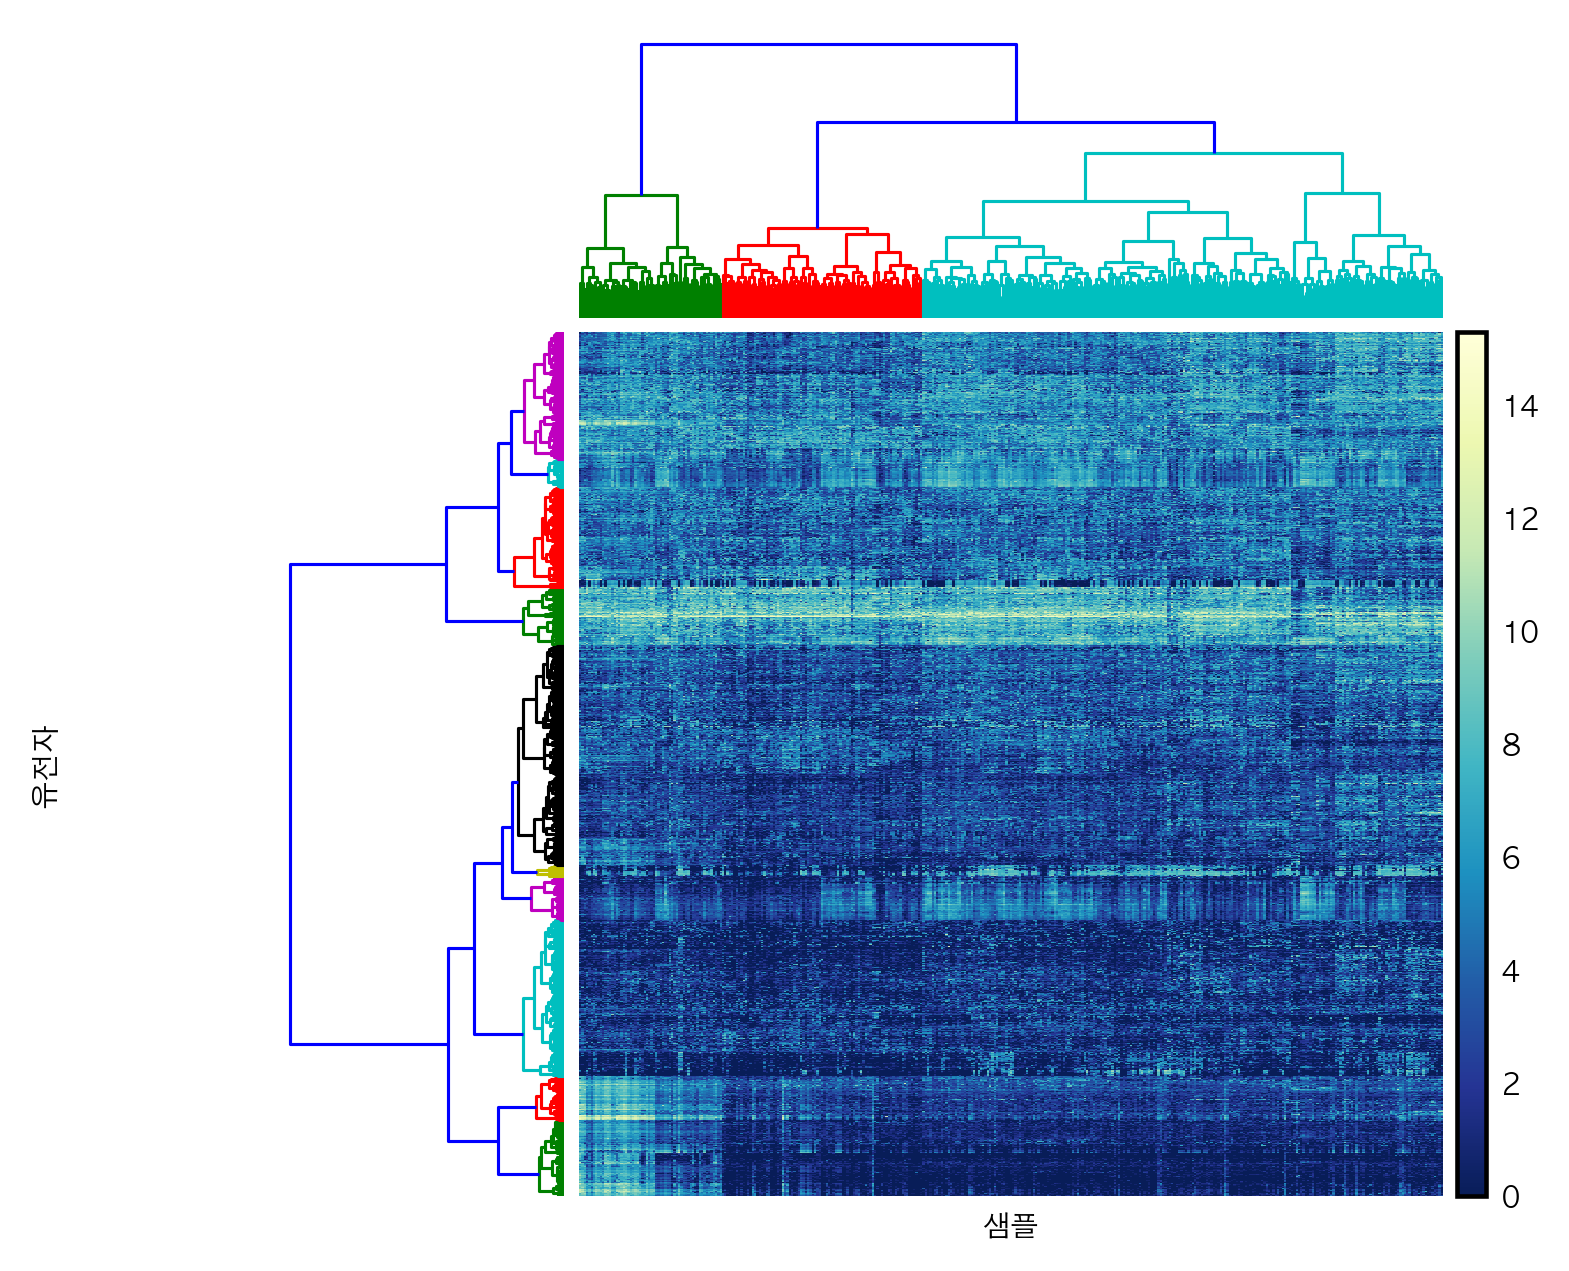

In [20]:
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward',
                           distance_metric='euclidean')
with plt.style.context('style/thinner.mplstyle'):
    plot_bicluster(counts_var, yr, yc)

## 2.5 생존율 예측

In [22]:
patients = pd.read_csv('data/patients.csv', index_col=0)
patients.head()

,UV-signature,original-clusters,melanoma-survival-time,melanoma-dead
TCGA-BF-A1PU,UV signature,keratin,NaN,NaN
TCGA-BF-A1PV,UV signature,keratin,13.0,0.0
TCGA-BF-A1PX,UV signature,keratin,NaN,NaN
TCGA-BF-A1PZ,UV signature,keratin,NaN,NaN
TCGA-BF-A1Q0,not UV,immune,17.0,0.0


In [26]:
def survival_distribution_function(lifetimes, right_censored=None):
    """수명(lifetimes) 집합의 생존 분포 함수를 반환한다.

    매개변수
    ----------
    lifetimes : 부동소수점 혹은 정수 배열
        관찰된 환자의 수명 (음수가 아니어야 함)
    right_censored : 불린 배열 (lifetimes 배열 모양과 같음)
     True는 수명이 관찰되지 않았다는 것을 의미한다.
     lifetimes 배열의 np.nan값은 범위를 넘어선(right-censored) 값으로 간주한다.

    반환값
    -------
    sorted_lifetimes : 부동소수점 배열
    sdf : 부동소수점 배열
     값은 1 부터 시작하여 점진적으로 감소한다.
     lifetimes 배열의 각 관찰에 대한 수준을 나타낸다.

    예제
    --------
    이번 예제에서 네 그룹의 환자 중 두 그룹은 1년 뒤에 사망하고,
    세 번째 그룹은 2년 뒤에 사망한다. 
    마지막 각 개인 그룹의 사망 시간은 알 수 없다(`np.nan`).

    >>> lifetimes = np.array([2, 1, 1, np.nan])
    >>> survival_distribution_function(lifetimes)
    (array([ 0.,  1.,  1.,  2.]), array([ 1.  ,  0.75,  0.5 ,  0.25]))
    """
    n_obs = len(lifetimes)
    rc = np.isnan(lifetimes)
    if right_censored is not None:
        rc |= right_censored
    observed = lifetimes[~rc]
    xs = np.concatenate( ([0], np.sort(observed)) )
    ys = np.linspace(1, 0, n_obs + 1)
    ys = ys[:len(xs)]
    return xs, ys

In [36]:
def plot_cluster_survival_curves(clusters, sample_names, patients, 
                                 censor=True):
    """Plot the survival data from a set of sample clusters.

    매개변수
    ----------
    clusters : 정수 배열 (pd.Series 열거형 변수)
        각 샘플의 군집 식별자
        팬더스 열거형 변수로 인코딩된 간단한 정수
    sample_names : 문자열 리스트
        각 샘플에 해당하는 이름
        clusters 변수와 같은 길이어야 한다.
    patients : 팬더스 데이터 프레임(pandas.DataFrame)
        데이터 프레임은 각 환자의 생존 정보가 포함되어 있다.
        데이터 프레임의 인덱스는 sample_names 리스트와 일치해야 한다.
        리스트에 없는 샘플은 무시된다.
    censor : 불린, 선택적 매개변수
        True인 경우,  patients['melanoma-dead']를 사용하여 
        생존 데이터를 비정상 값(right-censored)으로 체크한다.
    """
    fig, ax = plt.subplots()
    if type(clusters) == np.ndarray:
        cluster_ids = np.unique(clusters)
        cluster_names = ['군집 {}'.format(i) for i in cluster_ids]
    elif type(clusters) == pd.Series:
        cluster_ids = clusters.cat.categories
        cluster_names = list(cluster_ids)
    n_clusters = len(cluster_ids)
    for c in cluster_ids:
        clust_samples = np.flatnonzero(clusters == c)
        # 생존 데이터에 없는 환자를 제거한다.
        clust_samples = [sample_names[i] for i in clust_samples
                         if sample_names[i] in patients.index]
        patient_cluster = patients.loc[clust_samples]
        survival_times = patient_cluster['melanoma-survival-time'].values
        if censor:
            censored = ~patient_cluster['melanoma-dead'].values.astype(bool)
        else:
            censored = None
        stimes, sfracs = survival_distribution_function(survival_times,
                                                        censored)

        ax.plot(stimes / 365, sfracs)

    ax.set_xlabel('생존 시간 (년)')
    ax.set_ylabel('생존율')
    ax.legend(cluster_names)

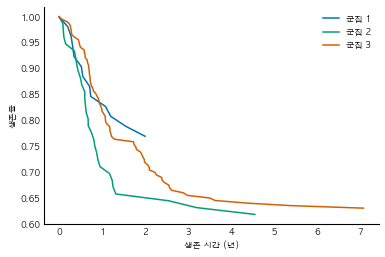

In [37]:
from scipy.cluster.hierarchy import fcluster

n_clusters = 3
threshold_distance = (yc[-n_clusters, 2] + yc[-n_clusters+1, 2]) / 2
clusters = fcluster(yc, threshold_distance, 'distance')

plot_cluster_survival_curves(clusters, data_table.columns, patients)